In [1]:
import pandas as pd
from ggplot import *
import numpy as np

project_id = "the-d-team-164512"

In [2]:
df_pharma_compass = pd.read_csv('../small_data/pharma_compass_patent_expiry.csv',
                               parse_dates=['Patent Expiration'])
df_pharma_compass['drug'] = df_pharma_compass['Product']
df_pharma_compass['drug'] = df_pharma_compass['drug'].apply(lambda x: str(x).upper())
df_pharma_compass['expiry'] = df_pharma_compass['Patent Expiration']

df_drugs_com = pd.read_csv('../small_data/drugs_com_patent_expiration.csv')
df_drugs_com['drug'] = df_drugs_com['drug'].apply(lambda x: x.upper())
df_drugs_com['expiry'] = df_drugs_com['expiry year']\
    .apply(lambda x: ('%d-12-31' % x))\
    .apply(pd.to_datetime, format='%Y-%m-%d')

df_new_drug_approvals = pd.read_csv('../small_data/new_drug_approvals_patent_expiry.csv',
                                    parse_dates=['expiry year'])
df_new_drug_approvals['drug'] = df_new_drug_approvals['drug'].apply(lambda x: x.upper())
df_new_drug_approvals['expiry'] = df_new_drug_approvals['expiry year']

df_patent_expiries = pd.DataFrame(df_new_drug_approvals[['expiry', 'drug']])
df_patent_expiries = pd.concat([df_patent_expiries, df_drugs_com[['expiry', 'drug']]])
df_patent_expiries = pd.concat([df_patent_expiries, df_pharma_compass[['expiry', 'drug']]])
df_patent_expiries.head(3)

df_drug_lookup = pd.read_csv('../../MelbDatathon2017/Lookups/Drug_LookUp.txt', sep="\t")
df_drug_lookup['drug'] = df_drug_lookup['BrandName']
df_drug_lookup

df = pd.merge(df_patent_expiries, df_drug_lookup, on='drug', how='inner')

for drug in list(set(df_patent_expiries.drug) - set(df.drug.unique())):
    first_drug_word = drug.split()[0].split(';')[0]
    if first_drug_word == None:
        first_drug_word = drug
    found = df_drug_lookup.drug.str.contains(first_drug_word)
    found = df_drug_lookup[df_drug_lookup.drug.str.contains(drug)]
    if len(found) > 0:
        df = df.append(found, ignore_index=True)
    else:
        found = df_drug_lookup[df_drug_lookup.MasterProductFullName.str.contains(first_drug_word)]
        found.drug = found.drug.apply(lambda x: drug)
        if len(found) > 0:
            df = df.append(found, ignore_index=True)
        else:
            found = df_drug_lookup[df_drug_lookup.GenericIngredientName.str.contains(first_drug_word)]
            found.drug = found.drug.apply(lambda x: drug)
            if len(found) > 0:
                df = df.append(found, ignore_index=True)

print("\n\nDrug IDs found")
print(len(df.drug.unique()))

print("\n\nIncluding drugs:")
print(df.drug.unique()[0 : 10])

print("\n\nNot Including drugs:")
print(list(set(df_patent_expiries.drug) - set(df.drug.unique()))[0 : 10])

print("\n\nDrug IDs NOT found")
print(len(list(set(df_patent_expiries.drug) - set(df.drug.unique()))))

# df[df.GenericIngredientName == 'AMLODIPINE'] # check a particular drug

/opt/boxen/homebrew/lib/python3.5/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value




Drug IDs found
217


Including drugs:
['LIPITOR' 'ZYPREXA' 'CONCERTA' 'PLAVIX' 'SEROQUEL' 'SINGULAIR' 'ACTOS'
 'ENBREL' 'RIZATRIPTAN' 'LEXAPRO']


Not Including drugs:
['CUBICIN', 'METAXALONE', 'RAMIPRIL', 'NITRIC OXIDE', 'NITROGLYCERIN', 'AMIAS', 'BENICAR', 'TRETINOIN', 'GEODON', 'ZICONOTIDE ACETATE']


Drug IDs NOT found
85


In [3]:
df.MasterProductID.unique()

query = """\
SELECT
  d.BrandName AS brand_name
  , DATE(t.Dispense_Week) AS date
  , COUNT(*) AS transaction_count
FROM [the-d-team-164512:dthon.transactions] t
JOIN [the-d-team-164512:dthon.drug_lookup] d
ON t.Drug_ID = d.MasterProductID
WHERE t.Drug_ID IN ({0})
GROUP BY
  brand_name
  , date
ORDER BY
  brand_name
  , date ASC
"""

drug_ids = ",".join(np.char.mod('%d', df.MasterProductID.unique()))
query = query.format(drug_ids)
df_patent = pd.read_gbq(query, project_id)
df_patent.date = pd.Series(df_patent.date).apply(pd.to_datetime, format='%Y-%m-%d')

df_patent.head(3)

Waiting for job to complete...


,brand_name,date,transaction_count
0,ABILIFY,2010-12-26,3
1,ABILIFY,2011-01-02,137
2,ABILIFY,2011-01-09,102


Lots of drop offs presumably around the drugs going off patent.

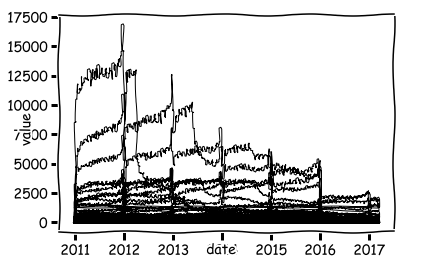

<ggplot: (293332088)>

In [4]:
df_patent_lng = pd.melt(df_patent, id_vars=['date', 'brand_name'])
ggplot(
    aes(x='date', y='value'), #, colour='brand_name'),
    data=df_patent_lng) +\
    geom_step() +\
    theme_xkcd()

Some more drop offs.

       expiry         drug
1  2011-12-31      ZYPREXA
3  2011-12-31     CONCERTA
5  2012-12-31       PLAVIX
6  2012-12-31     SEROQUEL
7  2012-12-31    SINGULAIR
8  2012-12-31        ACTOS
9  2012-12-31       ENBREL
10 2013-01-01  RIZATRIPTAN
0  2012-12-31       PLAVIX
1  2012-12-31     SEROQUEL
2  2012-12-31    SINGULAIR
3  2012-12-31        ACTOS
4  2012-12-31      LEXAPRO
14 2012-12-31     SEROQUEL
17 2012-12-31     SEROQUEL
19 2012-12-31    SINGULAIR
21 2012-12-31    SINGULAIR
25 2012-12-31     SEROQUEL
37 2013-12-31       PLAVIX
83 2015-12-31      ZYPREXA


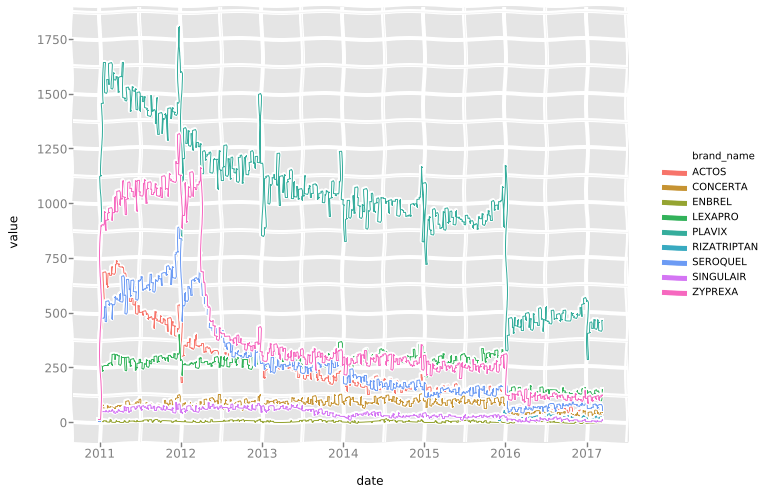

<ggplot: (295468408)>

In [5]:
some_drugs = ['ZYPREXA', 'CONCERTA', 'PLAVIX', 'SEROQUEL', 'SINGULAIR', 'ACTOS', 'ENBREL', 'RIZATRIPTAN', 'LEXAPRO']
df_patent_lng = pd.melt(df_patent[df_patent.brand_name.isin(some_drugs)], id_vars=['date', 'brand_name'])

print(df_patent_expiries[df_patent_expiries.drug.isin(some_drugs)])

ggplot(
    aes(x='date', y='value', colour='brand_name'),
    data=df_patent_lng) +\
    geom_step()
